# Тестирование двойственного алгоритма решения задачи минимизации максимального запаздывания

In [2]:
float('inf')

inf

In [6]:
type(sys.maxsize)

int

### Импорты

In [3]:
import time
import sys
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations
from scipy.optimize import curve_fit

### Класс "Расписание"

In [2]:
class Schedule:
    """
    A wrap around arrays of shape (n, 3), 
    where n is the number of jobs in the schedule
    and each job parameters are ordered as follows:
    r | p | d
    """
    array = None
    
    def __init__(self, array):
        """
        Arguments:
        - array: int or list/np.ndarray
        if int, the schedule is generated randomly and contains n elements
        if list/np.ndarray/etc., the array is directly transformed into schedule
        """
        if isinstance(array, int):
            self.array = np.random.randint(1, 1000, size=(array, 3))
            #self.array[:,2] = self.array[:,2] + self.array[:,1] + self.array[:,0] # for non-negative time slack
        else: self.array = np.copy(array)
    
    def show(self):
        print(" r  |  p  |  d ")
        print(self.array)
        
    def sort(self, item=0):
        self.array = self.array[self.array[:,item].argsort()]
        
    def remove(self, B):
        idx = []
        for i, e in enumerate(np.isin(self.array, B)):
            if e.all():
                idx.append(i)
        self.array = np.delete(self.array, idx, axis=0)
    
    def pop(self, index=-1):
        e = self.array[index]
        self.array = np.delete(self.array, index, axis=0)
        return e
    
    def copy(self):
        return Schedule(np.copy(self.array))
    
    def insert(self, index, elem):
        self.array = np.insert(self.array, index, elem, axis=0)
        
    def length(self):
        return self.array.shape[0]
    
    def C(self, j=None):
        t = 0
        for task in self.array[:j]:
            if t < task[0]:
                t = task[0]
            t += task[1]
        return t
    
    def timeshift(self, tau):
        for i in range(self.length()):
            self.array[i,0] -= tau
            
    def L_max(self, tau):
        if len(self.array) == 0:
            return 0
        a = self.copy()
        a.timeshift(tau)
        return max([self.C(j+1) - a.array[j,2] for j in range(len(a.array))]) + tau


### Алгоритм решения двойственной задачи

In [3]:
def dual(N, tau, B):
    pi_r = N.copy()
    pi_r.remove(B)
    #pi_r.timeshift(tau)
    pi_r.sort()
    bestC = pi_r.C()
    bestI = 0
    if True:
        for k, e in enumerate(pi_r.array):
            pi_k = pi_r.copy()
            i_k = pi_k.pop(k)
            if pi_k.length() > 0:
                i_l = pi_k.pop(np.argmin(pi_k.array, axis=0)[0])
                pi_k.insert(pi_k.length(), i_k)
                pi_k.insert(0, i_l)
                C_k = pi_k.C()
                if C_k < bestC:
                    bestC = C_k
                    bestI = k
        return bestC + tau, bestI
        

### Класс "пример"
Содержит все параметры примера, указанные в статье: $N,\tau, \nu, \pi, B$, при чём $\nu$ автоматически вычисляется применением двойственного алгоритма к $N$

In [4]:
class Instance:
    
    def __init__(self, N, tau, pi=Schedule([]), B=[]):
        """
        Arguments:
        - N - Schedule object
        - tau - int or (possibly) float
        - pi - Schedule object
        - B - list
        """
        self.N = N.copy()
        self.tau = tau
        self.nu = dual(N, tau, B)[0]
        self.pi = pi.copy()
        self.B = B.copy()
        
    def best_job(self):
        N1 = self.N.copy()
        N1.remove(self.B)
        if len(N1.array) == 0:
            return
        a = N1.array[N1.array[:,0] <= self.tau]
        if len(a) == 0:
            self.tau = np.min(N1.array[:,0], axis=0)
            a = N1.array[N1.array[:,0] <= self.tau]
        f = min(a, key=lambda x: x[2])
        return f

### Алгоритм решения задачи $1|r_j|L_{max}$

In [6]:
# timeout parameter sets maximum calculation time limit in seconds for one schedule
timeout = 1200

def main(N, tau):
    tb = time.time()
    c = 0
    bestPi = N.copy()    # в алгоритме сказано изначально задать pi* пустым множеством, но ведь тогда его Lateness будет нулём, и это pi* и будет всё время определяться в качетсве оптимального
    instances = [Instance(N, tau)]
    while len(instances) > 0:
        ti = time.time()
        if ti - tb > timeout:
            return Schedule([]), -1
        index, instance = min(enumerate(instances), key=lambda x: x[1].nu)
        f = instance.best_job()
        instances.pop(index)
        if f is not None:

            N1 = instance.N.copy()
            N1.remove(f)
            tau1 = max(f[0], instance.tau) + f[1]
            B1 = []
            a1 = np.copy(instance.pi.array)
            if len(a1) == 0:
                a1 = np.copy([f,])
            else:
                a1 = np.append(a1, [f,], axis=0)
            pi1 = Schedule(a1)
            i1 = Instance(N1, tau1, pi1, B1)

            N2 = instance.N
            tau2 = instance.tau
            if len(instance.B) == 0:
                B2 = np.copy([f,])
            else:
                B2 = np.append(instance.B, [f,], axis=0)
            pi2 = instance.pi
            i2 = Instance(N2, tau2, pi2, B2)

            instances += [i1, i2]
            c += 1

            if pi1.length() == N.length():
                if pi1.L_max(tau) < bestPi.L_max(tau):
                    bestPi = pi1.copy()
            #print("instance nu: %s\ni1 nu: %s\ni2 nu: %s" % (instance.nu, i1.nu, i2.nu))
            #print("Lmax:", bestPi.L_max(tau))
            instances = [i for i in instances if i.nu < bestPi.L_max(tau)]

    return bestPi, c

### Алгоритм перебора *всех* возможных вариантов

In [7]:
def bruteforce(S, tau=10000):
    N = np.copy(S.array)
    best_L = Schedule(N).L_max(tau)
    best_S = N
    for p in permutations(N):
        L = Schedule(p).L_max(tau)
        if L < best_L:
            best_L = L
            best_S = p
    return Schedule(best_S)

# Тестирование

### Подсчёт корректности работы алгоритма на примерах малой размерности
**Количество задач в примере:** от 2 до 5

**Количество примеров каждой размерности:** 1000

При этом решение, предложенное алгоритмом, сравнивается с решением, полученным методом перебора всех возможных вариантов без учёта запрета на прерывания - то есть перебором находится расписание с минимальным запаздыванием, пусть даже в этом расписании и встречаются прерывания

In [1556]:
tc = 0 # true counter - when the result is correct
fc = 0 # false counter - when the result is incorrect
for n in range(2, 5):
    for i in range(1000):
        print('\r', i, end='')
        t = random.randint(0, 1000)
        s = Schedule(n)
        result, count = main(s, t)
        result = result.L_max(t)
        realResult = bruteforce(s, t).L_max(t)
        if result == realResult:
            tc += 1
        else:
            fc += 1
    print(" --", n, "tasks")
print("\n", "-"*50, "\n Correct: %d%%\tIncorrect: %d%%" % (tc/(tc + fc)*100, fc/(tc + fc)*100))

 999 -- 2 tasks
 999 -- 3 tasks
 999 -- 4 tasks

 -------------------------------------------------- 
 Correct: 61%	Incorrect: 38%


### Оценка сложности алгоритма
Метрика - количество узлов ветвления

**Размерность примеров:** от 2 до 11

**Количество примеров каждой размерности:** 3, при этом учитываются только примеры, удовлетворяющие критериям:
1. Решение должно быть найдено за время не более 1200 секунд
2. Решение должно быть корректным: отбрасываются те 39% вариантов, решение которых находится за n ветвлений, где n -- размерность примера. Как показало изучение работы алгоритма, именно эти варианты решаются им некорректно из-за того, что $L_{max}$ случайно упорядоченного набора заданий оказывается меньше любого $\nu'$

In [8]:
results = dict()
for n in range(3, 21):
    results[n] = []
    while len(results[n]) != 3:
        print('\r', len(results[n]), end='')
        t = random.randint(0, 1000)
        s = Schedule(n)
        result, count = main(s, t)
        if count > n + 1:
            results[n].append(count)
    print(" --", n, "tasks")
    
    json.dump(results, open('results5.json', 'w'))

 2 -- 3 tasks
 2 -- 4 tasks
 2 -- 5 tasks
 2 -- 6 tasks
 2 -- 7 tasks
 2 -- 8 tasks
 2 -- 9 tasks
 2 -- 10 tasks
 1

KeyboardInterrupt: 

### Экспериментальная оценка производительности

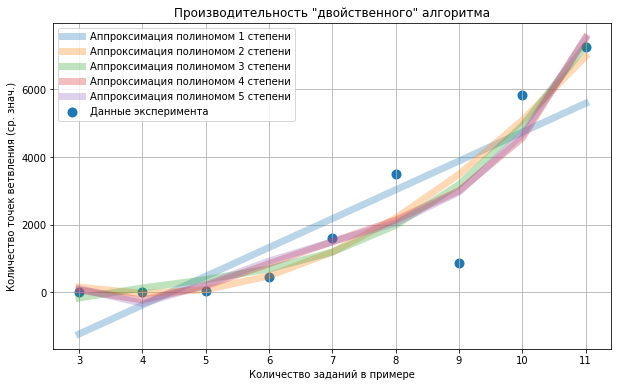

In [45]:
x = []
y = []
yf = []
for k in results.keys():
    if True:
        y.append(np.mean(results[k]))
        x.append(k)
        yf.append(np.math.factorial(k))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, title='Производительность "двойственного" алгоритма')
ax.grid()
ax.scatter(x, y, linewidth=4, label="Данные эксперимента")
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Количество точек ветвления (ср. знач.)")
for i in range(5):
    ax.plot(x, z[i](x), label='Аппроксимация полиномом %s степени' % (i+1), linewidth=7, alpha=0.3)
ax.legend()

In [21]:
z = []
for i in range(1, 6):
    z.append(np.poly1d(np.polyfit(x, y, i)))

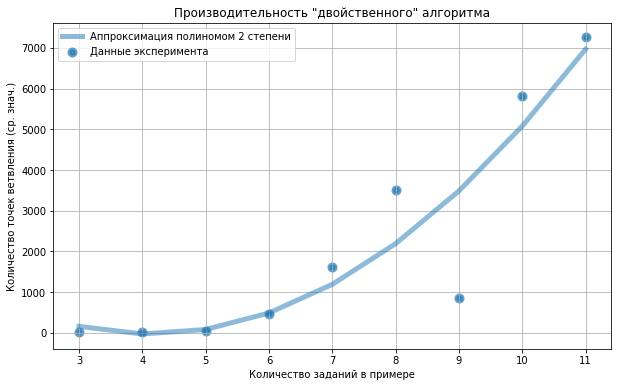

In [46]:
x = []
y = []
yf = []
for k in results.keys():
    if True:
        y.append(np.mean(results[k]))
        x.append(k)
        yf.append(np.math.factorial(k))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, title='Производительность "двойственного" алгоритма')
ax.grid()
ax.scatter(x, y, linewidth=4, alpha=0.7, label="Данные эксперимента")
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Количество точек ветвления (ср. знач.)")
i = 1
ax.plot(x, z[i](x), label='Аппроксимация полиномом %s степени' % (i+1), linewidth=5, alpha=0.5)
ax.legend()

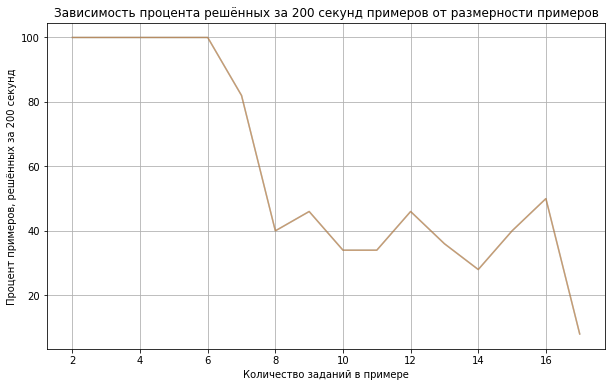

In [1571]:
x = []
y = []
for k in results:
    x.append(k)
    y.append(len(results[k])*2)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, title='Зависимость процента решённых за 200 секунд примеров от размерности примеров')
ax.grid()
ax.plot(x, y, alpha=0.5)
ax.set_xlabel("Количество заданий в примере")
ax.set_ylabel("Процент примеров, решённых за 200 секунд")
ax.plot(x, y, alpha=0.5)

# Итоги и выводы
1. На примерах малой размерности была протестирована корректность работы алгоритма. 61% примеров решаются им правильно.
2. Было оценено быстродействие алгоритма с лимитом времени в 200 секунд. График зависимости процента решённых за 200 секунд примеров от их размерности представлен выше. Всего исследовалось по 50 примеров каждой размерности.
3. Была оценена производительность алгоритма. В качестве метрики использовалось число точек ветвления. Оценивались лишь примеры, решённые за время не более 1200 секунд, и решённые при этом корректно.
4. Все неправильно решённые примеры провоцировали одну и ту же ошибку - по какой-то причине  $L_{max}$ случайно упорядоченного набора заданий оказывался меньше любого $\nu'$, и после подстановки на первое место в $\pi'$ каждого из заданий набора, алгоритм выдавал изначальный вариант расстановки заданий в качестве оптимального расписания.
5. В алгоритме в качестве изначального значения $\pi*$ задавалась случайная последовательность задач, так как если задать $\pi^*=\emptyset$, то это $\pi^*$ и будет оставаться оптимальным из-за того, что его значение $L_{max}=0$